# WER on single recording end to end

#### Common packages

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib notebook
import matplotlib.pylab as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from graphviz import Digraph
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

## Split Corpus into Recordings $\langle A_i,T_i \rangle$ and Transcription Splits $\langle A_{i,j}, T_{i,j} \rangle$ within Recordings

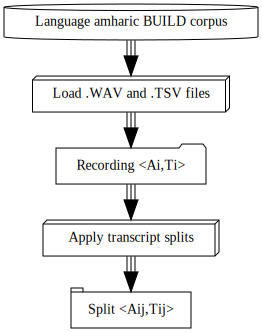

In [3]:
from Cfg import Cfg
import split_corpus_into_recordings_and_splits
C = Cfg('NIST', 8000, 'amharic') 
split_corpus_into_recordings_and_splits.diagram(C)

In [4]:
from RecordingCorpus import RecordingCorpus
from multiprocessing import Pool
if __name__ == '__main__':
    with Pool(16) as pool:
        recordings = RecordingCorpus(C, pool)

100%|██████████| 122/122 [00:02<00:00, 45.09it/s]


In [5]:
from SplitCorpus import SplitCorpus
splits=SplitCorpus.from_recordings(C, recordings)

## Subsplit $A_{i,j}$ on silence and apportion text to trimmed chunks by word sizes in $T_{i,j} = \langle w_{i,j,k} \rangle$ where $w_{i,j,k}=\langle g_{i,j,k,l} \rangle$

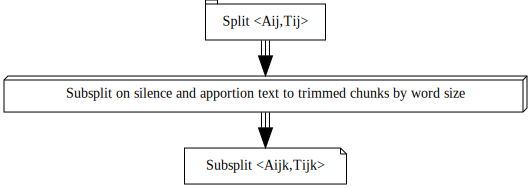

In [6]:
import subsplit_Aij_on_silence_and_apportion_text_by_size
subsplit_Aij_on_silence_and_apportion_text_by_size.diagram

In [7]:
from SubSplitCorpus import SubSplitCorpus

In [8]:
import pickle
with open('bfgpu.pkl', 'rb') as f:
    subsplits=pickle.load(f)

# Train ASR NN on subsplits $A_{i,j,k} \to P_{i,j,k} \approx T_{i,j,k}$

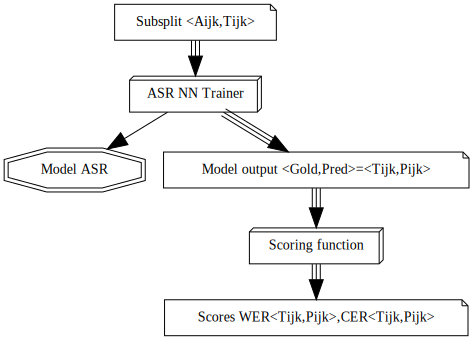

In [9]:
import train_ASR_NN_on_subsplits
train_ASR_NN_on_subsplits.diagram

In [10]:
import os
os.environ['IN_JUPYTER']='True'

In [11]:
from ASR_NN import ASR_NN

In [12]:
model_ASR = ASR_NN(C);

INFO:root:Trainer is initialized
DEBUG:tensorflow:Falling back to TensorFlow client; we recommended you install the Cloud TPU client directly with pip install cloud-tpu-client.


In [13]:
model_ASR.load_model();

INFO:root:Transformer(
  (encoder): Encoder(
    (dropout): Dropout(p=0.1, inplace=False)
    (input_linear): Linear(in_features=2560, out_features=512, bias=True)
    (layer_norm_input): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (positional_encoding): PositionalEncoding()
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn): MultiHeadAttention(
          (query_linear): Linear(in_features=512, out_features=512, bias=True)
          (key_linear): Linear(in_features=512, out_features=512, bias=True)
          (value_linear): Linear(in_features=512, out_features=512, bias=True)
          (attention): ScaledDotProductAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (softmax): Softmax(dim=2)
          )
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (output_linear): Linear(in_features=512, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (po

In [30]:
bad=[x for x in subsplits.artifacts if x.source.n_samples <=370]
good=[x for x in subsplits.artifacts if x.source.n_samples >370]
subsplits.artifacts=good
subsplits.problems=bad
from ArtifactsVector import ArtifactsVector
subsplits.population=ArtifactsVector(C, subsplits.artifacts)

In [34]:
from utils import constant
constant.args.augment=False

In [35]:
model_ASR.load_training_set(subsplits)

In [36]:
ASR_output = model_ASR.train()

INFO:root:name amharic_8000_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4_gradscaler


WELCOME TO PAN AMERICAN AIRWAYS


INFO:root:TRAIN
(Epoch 1) TRAIN LOSS:2.3831 CER:64.24% LR:0.0000112: 100%|██████████| 36282/36282 [36:32<00:00, 16.55it/s]
INFO:root:(Epoch 1) TRAIN LOSS:2.3831 CER:64.24% LR:0.0000112


SAVE MODEL to save/amharic_8000_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4_gradscaler/epoch_1__None_37429.th
SAVE MODEL to save/amharic_8000_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4_gradscaler/best_model.th
SAVE MODEL to save/amharic_8000_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4_gradscaler/epoch_1__None_37429.th
SAVE MODEL to save/amharic_8000_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4_gradscaler/best_model.th


In [38]:
ASR_output

[('እንደን', 'እንትን', 1, 1),
 ('አላት', 'ስንት', 2, 1),
 ('አዎትር', 'አራተኛ', 3, 1),
 ('አዎአጣ', 'አዎ በቃ', 2, 2),
 ('ስላም', 'ሰላም', 1, 1),
 ('እ', 'እ', 0, 0),
 ('እይቺ', 'አንቺ', 2, 1),
 ('እንለኝ', 'መሰለሽ', 3, 1),
 ('አይ', 'አባቱ', 2, 1),
 ('እሎ', 'ሄሎ', 1, 1),
 ('ስይ', 'ላይ', 1, 1),
 ('እንደያጣ', 'እንዲመጣ', 2, 1),
 ('አንፍ', 'አረጋግጠው', 5, 1),
 ('የነዚ', 'ለእዛ', 3, 1),
 ('እለ', 'ያው', 2, 1),
 ('እይ', 'ላይ', 1, 1),
 ('አሮአንደብ', 'ቡና እንጠጣ', 5, 2),
 ('አሺ', 'እኮ', 2, 1),
 ('እሎ', 'ቶሎ', 1, 1),
 ('አንደን', 'እንትን', 2, 1),
 ('አቃአውአለትነው', 'በቃ ነው ማለት ነው', 3, 4),
 ('አታ', 'ቦታም', 2, 1),
 ('እንደት', 'እንደት', 0, 0),
 ('እን', 'ግን', 1, 1),
 ('አጅስ', 'ልክ', 3, 1),
 ('እ', 'እ', 0, 0),
 ('ከንእንልራ', 'እዛ እያወራሁ', 5, 2),
 ('እን', 'እኛ', 1, 1),
 ('እቃንርት', 'በፀገነት', 4, 1),
 ('አንሱምአይ እይደለኝአንደያ', 'አክሱም ላይ አይደለ እንደዚያ', 6, 4),
 ('እ ደህና ናቸው ደውና ናቸው ደህና ናቸው', 'እ ደህና ናቸው ደህና ናቸው ደህና ናቸው', 1, 1),
 ('እመስልም', 'ተሰምቷላ', 5, 1),
 ('እን', 'እ', 1, 1),
 ('ሰናምን', 'ምናምን', 1, 1),
 ('ነምለ', 'የፍርድ', 4, 1),
 ('እንደ', 'እንደት', 1, 1),
 ('እራስ', 'ሴቲንጉ', 4, 1),
 ('እእር', 'ከድር', 2, 1),
 ('እውር', 'ነበር', 2, 1)

In [ ]:
ASR_scores = model_ASR.score(ASR_output)

In [37]:
os.getpid()

37429

Clean up GPU memory for next phase

In [ ]:
import torch
del model_ASR
torch.cuda.empty_cache() 

## Concatenate $P_{i,j,k}$ giving $P_{i,j} = P_{i,j,1}\|\cdots\|P_{i,j,-1}$

In [ ]:
import concatenate_Pikj_giving_Pij
concatenate_Pikj_giving_Pij.diagram

In [ ]:
Pijk=ASR_output.pred
Pij=ASR_NN_trainer.concatenate(Pijk)

## Train text-to-text corrector on both $P_{i,j,k} \to Q_{i,j,k} \approx T_{i,j,k}$ and $P_{i,j} \to Q_{i,j} \approx T_{i,j}$ and score

In [ ]:
import train_text_to_text_corrector_on_Pij_and_Pijk_and_score
train_text_to_text_corrector_on_Pij_and_Pijk_and_score.diagram

In [ ]:
torch.cuda.empty_cache()

## Subsplit $A_{i,j}$ on silence alone retaining timecode $(s_{i,j,k},e_{i,j,k})$ giving $A_{i,j} = \langle (\alpha_{i,j,k}, (s_{i,j,k},e_{i,j,k})) \rangle$ so that $\alpha_{i,j,k} = A_{i,j}[s_{i,j,k}:e_{i,j,k}]$

In [ ]:
import subsplit_Aij_on_silence_retaining_timecode
subsplit_Aij_on_silence_retaining_timecode.diagram

## Infer $(\alpha_{i,j,k}, (s_{i,j,k},e_{i,j,k})) \xrightarrow{ASR} p_{i,j,k} $

In [ ]:
import infer_aijk_giving_pijk
infer_aijk_giving_pijk.diagram

In [ ]:
torch.cuda.empty_cache() 

## Concatenate $p_{i,j,k} \to p_{i,j}$

In [ ]:
import concatenate_pikj_giving_pij
concatenate_pikj_giving_pij.diagram

## Infer $p_{i,j} \xrightarrow{TT} (q_{i,j},(s_{i,j,0},e_{i,j,-1}))$ 

In [ ]:
import infer_pij_giving_qij
infer_pij_giving_qij.diagram

In [ ]:
torch.cuda.empty_cache() 

## Concatenate $\langle \langle (q_{i,j,k},(s_{i,j,k},e_{i,j,k})) \rangle \rangle $ giving transcript $Q_i = \langle (q_{i,j}, (s_{i,j,0},e_{i,j,-1})) \rangle$

In [ ]:
import concatenate_qijk_giving_Qi
concatenate_qijk_giving_Qi.diagram

## Save transcript $Q_i$ in .CTM format

In [ ]:
import save_transcript_Qi_in_CTM_format
save_transcript_Qi_in_CTM_format.diagram

## Score $\langle T_i,Q_i\rangle$ using `sclite` for each recording individually

In [ ]:
import score_TiQi_using_sclite_per_recording
score_TiQi_using_sclite_per_recording.diagram

## Score $\langle T_i,Q_i\rangle$ using `sclite` collectively

In [ ]:
import score_TiQi_using_sclite_on_all_recordings_together
score_TiQi_using_sclite_on_all_recordings_together.diagram